In [1]:
## mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install snntorch
!pip install segmentation-models-pytorch

In [3]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import GradScaler, autocast
from pathlib import Path
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from torchvision import models
import snntorch as snn
from snntorch import surrogate
from snntorch import utils
import segmentation_models_pytorch as smp
# ==========================================
# 1. CONFIGURATION
# ==========================================
CONFIG = {
    "base_dir": "/content/drive/MyDrive/GlacierHack_practice/Train",
    "project_dir": "/content/drive/MyDrive/Glacier_SNN_Project_vggnet16",
    "model_type": "CNN",   # Start with CNN, then switch to SNN
    "time_steps": 6,
    "beta": 0.9,
    "epochs": 30,
    "batch_size": 4,
    "lr": 1e-4,
    "num_workers": 2,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

os.makedirs(CONFIG['project_dir'], exist_ok=True)

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)

# ==========================================
# 2. DATASET
# ==========================================
class GlacierDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.base_dir = Path(base_dir)
        self.band_dirs = [self.base_dir / f"Band{i}" for i in range(1, 6)]
        self.label_dir = self.base_dir / "labels"
        self.ids = sorted([p.stem for p in self.band_dirs[0].glob("*.tif")])
        self.transform = transform

    def __len__(self): return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        bands = [cv2.imread(str(d / f"{img_id}.tif"), cv2.IMREAD_UNCHANGED).astype(np.float32) for d in self.band_dirs]
        image = np.stack(bands, axis=-1)
        label = cv2.imread(str(self.label_dir / f"{img_id}.tif"), cv2.IMREAD_UNCHANGED)
        if label.ndim == 3: label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
        mask = np.zeros_like(label, dtype=np.uint8)
        mask[label == 85] = 1; mask[label == 170] = 2; mask[label == 255] = 3

        p02, p98 = np.percentile(image, 2), np.percentile(image, 98)
        image = np.clip(image, p02, p98)
        image = (image - image.min()) / (image.max() - image.min() + 1e-6)

        if self.transform:
            aug = self.transform(image=image, mask=mask)
            return aug["image"].float(), aug["mask"].long()
        return torch.tensor(image.transpose(2,0,1)).float(), torch.tensor(mask).long()

class Wrapper(Dataset):
    def __init__(self, ds, t): self.ds, self.t = ds, t
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        img, mask = self.ds[i]
        img = img.numpy().transpose(1,2,0); mask = mask.numpy()
        res = self.t(image=img, mask=mask)
        return res['image'], res['mask'].long()

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.RandomRotate90(p=0.5),
    A.GridDistortion(p=0.3),
    ToTensorV2(),
])
val_transform = A.Compose([ToTensorV2()])

full_dataset = GlacierDataset(CONFIG['base_dir'], transform=None)
val_len = int(len(full_dataset)*0.2)
train_ds, val_ds = random_split(full_dataset, [len(full_dataset)-val_len, val_len])

train_loader = DataLoader(Wrapper(train_ds, train_transform), batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2)
val_loader = DataLoader(Wrapper(val_ds, val_transform), batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

# ==========================================
# 3. FIXED VGG16 U-NET (Correct Dimensions)
# ==========================================
class UnifiedEncoder(nn.Module):
    def __init__(self, mode="CNN"):
        super().__init__()
        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)
        features = list(vgg.features.children())

        # Fix input channel count (3 -> 5)
        old_conv0 = features[0]
        new_conv0 = nn.Conv2d(5, 64, kernel_size=3, padding=1)
        with torch.no_grad():
            new_conv0.weight[:, :3] = old_conv0.weight
            new_conv0.weight[:, 3:] = old_conv0.weight[:, :2]
        features[0] = new_conv0

        self.layers = nn.ModuleList()
        spike_grad = surrogate.atan()

        for layer in features:
            if isinstance(layer, nn.ReLU):
                if mode == "SNN":
                    self.layers.append(snn.Leaky(beta=CONFIG['beta'], spike_grad=spike_grad, init_hidden=True))
                else:
                    self.layers.append(layer)
            else:
                self.layers.append(layer)

    def forward(self, x):
        features = []
        out = x

        # VGG16_BN has pools at indices: 6, 13, 23, 33, 43
        # We capture features BEFORE pooling

        # Block 1 (Output: 512x512)
        for i in range(6): out = self.layers[i](out)
        features.append(out) # x1
        out = self.layers[6](out) # Pool

        # Block 2 (Output: 256x256)
        for i in range(7, 13): out = self.layers[i](out)
        features.append(out) # x2
        out = self.layers[13](out) # Pool

        # Block 3 (Output: 128x128)
        for i in range(14, 23): out = self.layers[i](out)
        features.append(out) # x3
        out = self.layers[23](out) # Pool

        # Block 4 (Output: 64x64)
        for i in range(24, 33): out = self.layers[i](out)
        features.append(out) # x4
        out = self.layers[33](out) # Pool

        # Block 5 (Output: 32x32)
        for i in range(34, 43): out = self.layers[i](out)
        features.append(out) # x5
        out = self.layers[43](out) # Pool -> 16x16 (Bottleneck)

        features.append(out) # Add bottleneck for convenience
        return features

class UnifiedDecoder(nn.Module):
    def __init__(self, mode="CNN"):
        super().__init__()
        spike_grad = surrogate.atan()

        def block(in_c, out_c):
            activation = snn.Leaky(beta=CONFIG['beta'], spike_grad=spike_grad, init_hidden=True) if mode == "SNN" else nn.ReLU(inplace=True)
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                activation
            )

        # 5 Upsampling Steps to go from 16 -> 512

        # 1. 16 -> 32 (Connect with x5)
        self.up5 = nn.ConvTranspose2d(512, 512, 2, 2)
        self.dec5 = block(512+512, 512)

        # 2. 32 -> 64 (Connect with x4)
        self.up4 = nn.ConvTranspose2d(512, 512, 2, 2)
        self.dec4 = block(512+512, 512)

        # 3. 64 -> 128 (Connect with x3)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec3 = block(256+256, 256)

        # 4. 128 -> 256 (Connect with x2)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec2 = block(128+128, 128)

        # 5. 256 -> 512 (Connect with x1)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec1 = block(64+64, 64)

        self.final = nn.Conv2d(64, 4, 1)

    def forward(self, x_bottleneck, enc_features):
        # enc_features has [x1, x2, x3, x4, x5]
        x5, x4, x3, x2, x1 = enc_features[4], enc_features[3], enc_features[2], enc_features[1], enc_features[0]

        u5 = self.up5(x_bottleneck)
        if u5.shape != x5.shape: u5 = F.interpolate(u5, size=x5.shape[2:])
        d5 = self.dec5(torch.cat([x5, u5], 1))

        u4 = self.up4(d5)
        if u4.shape != x4.shape: u4 = F.interpolate(u4, size=x4.shape[2:])
        d4 = self.dec4(torch.cat([x4, u4], 1))

        u3 = self.up3(d4)
        if u3.shape != x3.shape: u3 = F.interpolate(u3, size=x3.shape[2:])
        d3 = self.dec3(torch.cat([x3, u3], 1))

        u2 = self.up2(d3)
        if u2.shape != x2.shape: u2 = F.interpolate(u2, size=x2.shape[2:])
        d2 = self.dec2(torch.cat([x2, u2], 1))

        u1 = self.up1(d2)
        if u1.shape != x1.shape: u1 = F.interpolate(u1, size=x1.shape[2:])
        d1 = self.dec1(torch.cat([x1, u1], 1))

        return self.final(d1)

class UnifiedUNet(nn.Module):
    def __init__(self, mode="CNN"):
        super().__init__()
        self.mode = mode
        print(f"⏳ Initializing {mode} VGG16 U-Net (Fixed)...")
        self.encoder = UnifiedEncoder(mode)
        self.decoder = UnifiedDecoder(mode)

    def forward(self, x):
        if self.mode == "SNN":
            utils.reset(self)
            spk_rec = []
            for step in range(CONFIG['time_steps']):
                enc_feats = self.encoder(x)
                # enc_feats is [x1, x2, x3, x4, x5, bottleneck]
                bottleneck = enc_feats[-1]
                skips = enc_feats[:-1]

                out = self.decoder(bottleneck, skips)
                spk_rec.append(out)
            return torch.stack(spk_rec).mean(0)
        else:
            enc_feats = self.encoder(x)
            bottleneck = enc_feats[-1]
            skips = enc_feats[:-1]
            return self.decoder(bottleneck, skips)

# ==========================================
# 4. UTILS & TRAINING
# ==========================================
import segmentation_models_pytorch as smp
class HybridLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.ce = nn.CrossEntropyLoss()
        self.lovasz = smp.losses.LovaszLoss(mode='multiclass', per_image=True)
    def forward(self, inputs, targets):
        return 0.5 * self.ce(inputs, targets) + 0.5 * self.lovasz(inputs, targets)

def save_artifacts(history, sample_vis, epoch, mode):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1); plt.plot(history['loss']); plt.title(f"{mode} Loss")
    plt.subplot(1, 2, 2); plt.plot(history['mcc']); plt.title(f"{mode} MCC")
    plt.savefig(f"{CONFIG['project_dir']}/{mode}_history.png"); plt.close()

model = UnifiedUNet(mode=CONFIG['model_type']).to(CONFIG['device'])
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'])
criterion = HybridLoss()
scaler = GradScaler()

best_mcc = -1.0
history = {'loss': [], 'mcc': []}

print(f"🔥 Starting {CONFIG['model_type']} Training...")

for epoch in range(CONFIG['epochs']):
    model.train()
    running_loss = 0

    for imgs, masks in tqdm(train_loader, desc=f"Ep {epoch+1}"):
        imgs, masks = imgs.to(CONFIG['device']), masks.to(CONFIG['device']).long()
        optimizer.zero_grad()
        with autocast():
            out = model(imgs)
            loss = criterion(out, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    # Val
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(CONFIG['device'])
            with autocast():
                out = model(imgs)
            preds.append(out.argmax(1).cpu())
            targets.append(masks.cpu())

    mcc = matthews_corrcoef(torch.cat(targets).numpy().flatten(), torch.cat(preds).numpy().flatten())
    history['mcc'].append(mcc)
    history['loss'].append(running_loss/len(train_loader))

    print(f"Ep {epoch+1} | Val MCC: {mcc:.4f}")
    save_artifacts(history, None, epoch+1, CONFIG['model_type'])

    if mcc > best_mcc:
        best_mcc = mcc
        torch.save(model.state_dict(), f"{CONFIG['project_dir']}/best_{CONFIG['model_type']}_Fixed.pth")
        print("✅ Saved Best Model!")

print(f"🏁 Finished. Best MCC: {best_mcc:.4f}")

⏳ Initializing CNN VGG16 U-Net (Fixed)...


/tmp/ipython-input-444199384.py:277: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


🔥 Starting CNN Training...


Ep 1:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 1: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 1 | Val MCC: -0.0129
✅ Saved Best Model!


Ep 2:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 2: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 2 | Val MCC: 0.0334
✅ Saved Best Model!


Ep 3:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 3: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 3 | Val MCC: 0.2329
✅ Saved Best Model!


Ep 4:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 4: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 4 | Val MCC: 0.2852
✅ Saved Best Model!


Ep 5:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 5: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 5 | Val MCC: 0.3286
✅ Saved Best Model!


Ep 6:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 6: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 6 | Val MCC: 0.4296
✅ Saved Best Model!


Ep 7:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 7: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 7 | Val MCC: 0.5289
✅ Saved Best Model!


Ep 8:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 8: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 8 | Val MCC: 0.5827
✅ Saved Best Model!


Ep 9:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 9: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 9 | Val MCC: 0.6217
✅ Saved Best Model!


Ep 10:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 10: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 10 | Val MCC: 0.6025


Ep 11:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 11: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 11 | Val MCC: 0.6175


Ep 12:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 12: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 12 | Val MCC: 0.6378
✅ Saved Best Model!


Ep 13:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 13: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 13 | Val MCC: 0.5993


Ep 14:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 14: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 14 | Val MCC: 0.6423
✅ Saved Best Model!


Ep 15:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 15: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 15 | Val MCC: 0.6420


Ep 16:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 16: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 16 | Val MCC: 0.6223


Ep 17:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 17: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 17 | Val MCC: 0.6606
✅ Saved Best Model!


Ep 18:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 18: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 18 | Val MCC: 0.6732
✅ Saved Best Model!


Ep 19:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 19: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 19 | Val MCC: 0.6618


Ep 20:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 20: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 20 | Val MCC: 0.6684


Ep 21:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 21: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 21 | Val MCC: 0.6827
✅ Saved Best Model!


Ep 22:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 22: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 22 | Val MCC: 0.6707


Ep 23:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 23: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 23 | Val MCC: 0.6722


Ep 24:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 24: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 24 | Val MCC: 0.6759


Ep 25:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 25: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 25 | Val MCC: 0.6901
✅ Saved Best Model!


Ep 26:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 26: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 26 | Val MCC: 0.6702


Ep 27:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 27: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 27 | Val MCC: 0.6953
✅ Saved Best Model!


Ep 28:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 28: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 28 | Val MCC: 0.6796


Ep 29:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 29: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 29 | Val MCC: 0.6662


Ep 30:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-444199384.py:291: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Ep 30: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]
/tmp/ipython-input-444199384.py:305: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 30 | Val MCC: 0.6935
🏁 Finished. Best MCC: 0.6953


⏳ Loading CNN Model from /content/drive/MyDrive/Glacier_SNN_Project_vggnet16/best_CNN_Fixed.pth...
✅ Model Loaded Successfully!
🔍 Hunting for the best visual sample in validation set...
   ✨ Found new best! MCC: 0.5780
   ✨ Found new best! MCC: 0.7123
   ✨ Found new best! MCC: 0.7775


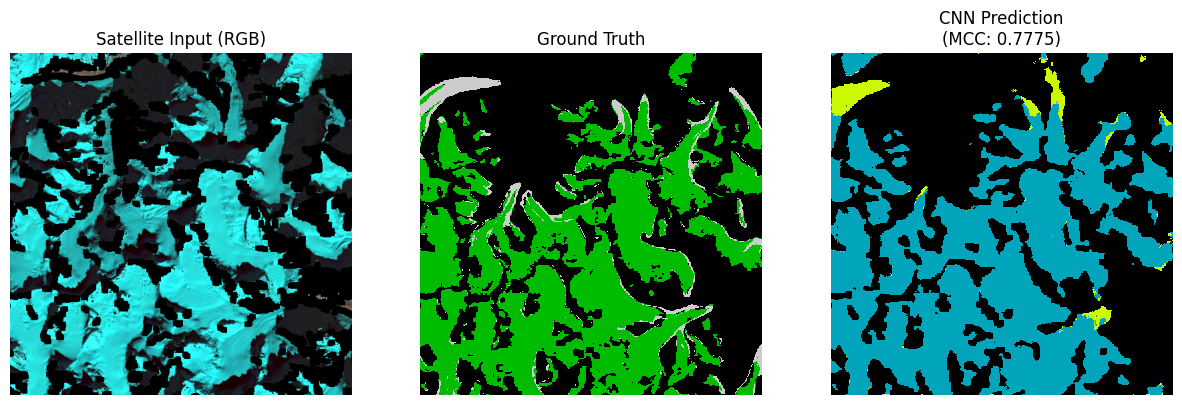

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from pathlib import Path
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import matthews_corrcoef
from torchvision import models
import snntorch as snn
from snntorch import surrogate
from snntorch import utils

# --- CONFIG ---
# Ensure this matches where your files are!
PROJECT_DIR = "/content/drive/MyDrive/Glacier_SNN_Project_vggnet16"
DATA_DIR = "/content/drive/MyDrive/GlacierHack_practice/Train"
MODEL_TYPE = "CNN" # Change to "SNN" to visualize the Spiking Model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to the model file
MODEL_PATH = f"{PROJECT_DIR}/best_{MODEL_TYPE}_Fixed.pth"

# ==========================================
# 1. EXACT MODEL ARCHITECTURE (COPY-PASTE)
# ==========================================
# We must define the classes EXACTLY as they were during training
class UnifiedEncoder(nn.Module):
    def __init__(self, mode="CNN"):
        super().__init__()
        self.mode = mode
        vgg = models.vgg16_bn(weights=None) # No need to download weights for inference
        features = list(vgg.features.children())

        # input channel count (3 -> 5)
        old_conv0 = features[0]
        new_conv0 = nn.Conv2d(5, 64, kernel_size=3, padding=1)
        features[0] = new_conv0

        self.layers = nn.ModuleList()
        spike_grad = surrogate.atan()

        # SNN Params (Must match training)
        beta = 0.9

        for layer in features:
            if isinstance(layer, nn.ReLU):
                if mode == "SNN":
                    self.layers.append(snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True))
                else:
                    self.layers.append(layer)
            else:
                self.layers.append(layer)

    def forward(self, x):
        out = x
        features = []
        # Block 1
        for i in range(6): out = self.layers[i](out)
        features.append(out) # x1
        out = self.layers[6](out) # Pool

        # Block 2
        for i in range(7, 13): out = self.layers[i](out)
        features.append(out) # x2
        out = self.layers[13](out)

        # Block 3
        for i in range(14, 23): out = self.layers[i](out)
        features.append(out) # x3
        out = self.layers[23](out)

        # Block 4
        for i in range(24, 33): out = self.layers[i](out)
        features.append(out) # x4
        out = self.layers[33](out)

        # Block 5
        for i in range(34, 43): out = self.layers[i](out)
        features.append(out) # x5
        out = self.layers[43](out) # Bottleneck

        features.append(out)
        return features

class UnifiedDecoder(nn.Module):
    def __init__(self, mode="CNN"):
        super().__init__()
        spike_grad = surrogate.atan()
        beta = 0.9

        def block(in_c, out_c):
            activation = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True) if mode == "SNN" else nn.ReLU(inplace=True)
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                activation
            )

        self.up5 = nn.ConvTranspose2d(512, 512, 2, 2)
        self.dec5 = block(512+512, 512)
        self.up4 = nn.ConvTranspose2d(512, 512, 2, 2)
        self.dec4 = block(512+512, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec3 = block(256+256, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec2 = block(128+128, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec1 = block(64+64, 64)
        self.final = nn.Conv2d(64, 4, 1)

    def forward(self, x_bottleneck, enc_features):
        x5, x4, x3, x2, x1 = enc_features[4], enc_features[3], enc_features[2], enc_features[1], enc_features[0]

        u5 = self.up5(x_bottleneck)
        if u5.shape != x5.shape: u5 = F.interpolate(u5, size=x5.shape[2:])
        d5 = self.dec5(torch.cat([x5, u5], 1))

        u4 = self.up4(d5)
        if u4.shape != x4.shape: u4 = F.interpolate(u4, size=x4.shape[2:])
        d4 = self.dec4(torch.cat([x4, u4], 1))

        u3 = self.up3(d4)
        if u3.shape != x3.shape: u3 = F.interpolate(u3, size=x3.shape[2:])
        d3 = self.dec3(torch.cat([x3, u3], 1))

        u2 = self.up2(d3)
        if u2.shape != x2.shape: u2 = F.interpolate(u2, size=x2.shape[2:])
        d2 = self.dec2(torch.cat([x2, u2], 1))

        u1 = self.up1(d2)
        if u1.shape != x1.shape: u1 = F.interpolate(u1, size=x1.shape[2:])
        d1 = self.dec1(torch.cat([x1, u1], 1))
        return self.final(d1)

class UnifiedUNet(nn.Module):
    def __init__(self, mode="CNN"):
        super().__init__()
        self.mode = mode
        self.encoder = UnifiedEncoder(mode)
        self.decoder = UnifiedDecoder(mode)

    def forward(self, x):
        if self.mode == "SNN":
            utils.reset(self)
            spk_rec = []
            for step in range(6): # Time Steps = 6 (Matched to Training)
                enc_feats = self.encoder(x)
                bottleneck = enc_feats[-1]
                skips = enc_feats[:-1]
                out = self.decoder(bottleneck, skips)
                spk_rec.append(out)
            return torch.stack(spk_rec).mean(0)
        else:
            enc_feats = self.encoder(x)
            bottleneck = enc_feats[-1]
            skips = enc_feats[:-1]
            return self.decoder(bottleneck, skips)

# ==========================================
# 2. DATASET & LOADER
# ==========================================
class GlacierDataset(Dataset):
    def __init__(self, base_dir):
        self.base_dir = Path(base_dir)
        self.band_dirs = [self.base_dir / f"Band{i}" for i in range(1, 6)]
        self.label_dir = self.base_dir / "labels"
        self.ids = sorted([p.stem for p in self.band_dirs[0].glob("*.tif")])
    def __len__(self): return len(self.ids)
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        bands = [cv2.imread(str(d / f"{img_id}.tif"), cv2.IMREAD_UNCHANGED).astype(np.float32) for d in self.band_dirs]
        image = np.stack(bands, axis=-1)
        label = cv2.imread(str(self.label_dir / f"{img_id}.tif"), cv2.IMREAD_UNCHANGED)
        if label.ndim == 3: label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
        mask = np.zeros_like(label, dtype=np.uint8)
        mask[label == 85] = 1; mask[label == 170] = 2; mask[label == 255] = 3

        p02, p98 = np.percentile(image, 2), np.percentile(image, 98)
        image = np.clip(image, p02, p98)
        image = (image - image.min()) / (image.max() - image.min() + 1e-6)

        aug = A.Compose([ToTensorV2()])(image=image, mask=mask)
        return aug["image"].float(), aug["mask"].long()

# Load Data
full_ds = GlacierDataset(DATA_DIR)
# Use the same split seed (42) to ensure we test on validation data
val_len = int(len(full_ds)*0.2)
_, val_ds = random_split(full_ds, [len(full_ds)-val_len, val_len], generator=torch.Generator().manual_seed(42))
loader = DataLoader(val_ds, batch_size=1, shuffle=False)

# ==========================================
# 3. LOAD MODEL & FIND BEST SAMPLE
# ==========================================
print(f"⏳ Loading {MODEL_TYPE} Model from {MODEL_PATH}...")

try:
    model = UnifiedUNet(mode=MODEL_TYPE).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("✅ Model Loaded Successfully!")
except Exception as e:
    print(f"❌ Failed to load model: {e}")
    print("Please ensure you ran the correct training script (CNN or SNN) first!")
    exit()

print("🔍 Hunting for the best visual sample in validation set...")

best_score = -1.0
best_data = None
count = 0

with torch.no_grad():
    for img, gt in loader:
        if count > 100: break # Check first 100 images
        count += 1

        img = img.to(DEVICE)

        # Predict
        if MODEL_TYPE == "SNN": utils.reset(model)
        out = model(img)
        pred = out.argmax(1).cpu().numpy()[0]

        # Check Score
        gt_np = gt.numpy()[0]
        score = matthews_corrcoef(gt_np.flatten(), pred.flatten())

        if score > best_score:
            best_score = score
            best_data = (img.cpu(), gt[0], pred, score)
            print(f"   ✨ Found new best! MCC: {score:.4f}")

# ==========================================
# 4. VISUALIZE
# ==========================================
if best_data:
    img, gt, pred, score = best_data

    # RGB Prep
    rgb = img[0].numpy()[[3,2,1]].transpose(1,2,0)
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb)
    plt.title("Satellite Input (RGB)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt, cmap='nipy_spectral', interpolation='nearest')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap='nipy_spectral', interpolation='nearest')
    plt.title(f"{MODEL_TYPE} Prediction\n(MCC: {score:.4f})")
    plt.axis('off')

    plt.show()
else:
    print("❌ No valid samples found.")